##Импорт библиотек

In [1]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.8 MB/s eta 0:00:00


In [2]:
!pip install -q phik

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 8.4 MB/s eta 0:00:00


In [3]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.9 MB/s eta 0:00:00


In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import CatBoostEncoder
from scipy import stats
from sklearn.preprocessing import PowerTransformer
import phik
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split
from catboost import Pool, cv, CatBoostClassifier
from IPython.core.debugger import set_trace
import joblib

##Импорт датасетов

In [155]:
train_df = pd.read_csv('df_train.csv')
test_df = pd.read_csv('df_test.csv')
train_df['target'].value_counts()

,count
target,
0,92211
1,13354


Проверка на отсутствующие значения

In [6]:
train_df.dropna()
train_df.describe()

,user_id,nm_id,total_ordered,count_items,unique_items,avg_unique_purchase,is_courier,NmAge,Distance,DaysAfterRegistration,number_of_orders,number_of_ordered_items,mean_number_of_ordered_items,min_number_of_ordered_items,max_number_of_ordered_items,mean_percent_of_ordered_items,target
count,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000
mean,21169.816056,19504.235305,30.262322,256.541562,34.933851,0.403886,0.013243,5518.167887,1554.587572,1368.405589,20.504665,145.566902,30.249259,25.561417,36.207900,45.643031,0.126500
std,12481.936785,13426.109359,40.532477,1023.116291,141.116667,0.406656,0.114314,8667.012801,1657.277528,995.599647,58.990701,2196.753376,38.607053,36.717645,44.659212,41.786504,0.332414
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.041946,0.000000
25%,9399.000000,6057.000000,1.000000,0.000000,0.000000,0.000000,0.000000,153.000000,472.000000,551.000000,1.000000,27.000000,1.649123,1.000000,3.000000,4.545455,0.000000
50%,22640.000000,20774.000000,14.000000,22.000000,13.000000,0.250000,0.000000,363.000000,1066.000000,1344.000000,3.000000,56.000000,15.000000,10.000000,20.000000,33.333333,0.000000
75%,34319.000000,33684.000000,50.000000,107.000000,39.000000,0.860000,0.000000,20004.000000,1995.000000,1843.000000,22.000000,94.000000,50.000000,50.000000,50.000000,100.000000,0.000000
max,35433.000000,37224.000000,627.000000,203303.000000,19984.000000,1.000000,1.000000,20120.000000,13381.000000,5839.000000,2384.000000,385200.000000,627.000000,627.000000,627.000000,100.000000,1.000000


Преобразем CreatedDate в float (количество секунд с начала эпохи)



In [7]:
#Преобразем CreatedDate в float (количество секунд с начала эпохи)
train_df_date = train_df
train_df_date['CreatedDate'] = pd.to_datetime(train_df_date['CreatedDate'], utc=True)
train_df_date['CreatedDate'] = train_df_date['CreatedDate'].astype('int64')/ 1e9

In [8]:
#для категориальной информации используем Catboost
cat_cols = ['service', 'PaymentType']
encoder = CatBoostEncoder(cols=cat_cols)
df_encoded = encoder.fit_transform(train_df_date[cat_cols], train_df_date['target'])
train_df_nocat = train_df_date.drop(columns=cat_cols)
train_df_nocat = pd.concat([train_df_nocat, df_encoded], axis=1)
train_df_nocat.describe()

,user_id,nm_id,CreatedDate,total_ordered,count_items,unique_items,avg_unique_purchase,is_courier,NmAge,Distance,DaysAfterRegistration,number_of_orders,number_of_ordered_items,mean_number_of_ordered_items,min_number_of_ordered_items,max_number_of_ordered_items,mean_percent_of_ordered_items,target,service,PaymentType
count,105565.000000,105565.000000,1.055650e+05,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000
mean,21169.816056,19504.235305,1.733066e+09,30.262322,256.541562,34.933851,0.403886,0.013243,5518.167887,1554.587572,1368.405589,20.504665,145.566902,30.249259,25.561417,36.207900,45.643031,0.126500,0.103850,0.108225
std,12481.936785,13426.109359,2.672130e+06,40.532477,1023.116291,141.116667,0.406656,0.114314,8667.012801,1657.277528,995.599647,58.990701,2196.753376,38.607053,36.717645,44.659212,41.786504,0.332414,0.025730,0.036973
min,1.000000,1.000000,1.727698e+09,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.041946,0.000000,0.011500,0.000279
25%,9399.000000,6057.000000,1.731295e+09,1.000000,0.000000,0.000000,0.000000,0.000000,153.000000,472.000000,551.000000,1.000000,27.000000,1.649123,1.000000,3.000000,4.545455,0.000000,0.087669,0.089881
50%,22640.000000,20774.000000,1.733102e+09,14.000000,22.000000,13.000000,0.250000,0.000000,363.000000,1066.000000,1344.000000,3.000000,56.000000,15.000000,10.000000,20.000000,33.333333,0.000000,0.105304,0.104112
75%,34319.000000,33684.000000,1.734622e+09,50.000000,107.000000,39.000000,0.860000,0.000000,20004.000000,1995.000000,1843.000000,22.000000,94.000000,50.000000,50.000000,50.000000,100.000000,0.000000,0.118916,0.115733
max,35433.000000,37224.000000,1.738356e+09,627.000000,203303.000000,19984.000000,1.000000,1.000000,20120.000000,13381.000000,5839.000000,2384.000000,385200.000000,627.000000,627.000000,627.000000,100.000000,1.000000,0.362218,0.531625


<Axes: ylabel='PaymentType'>

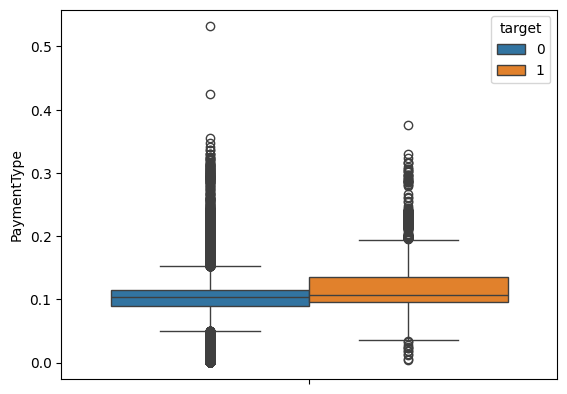

In [ ]:
sns.boxplot(y = 'PaymentType', hue = 'target', data=train_df_nocat, orient = 'v')

Распределения данных

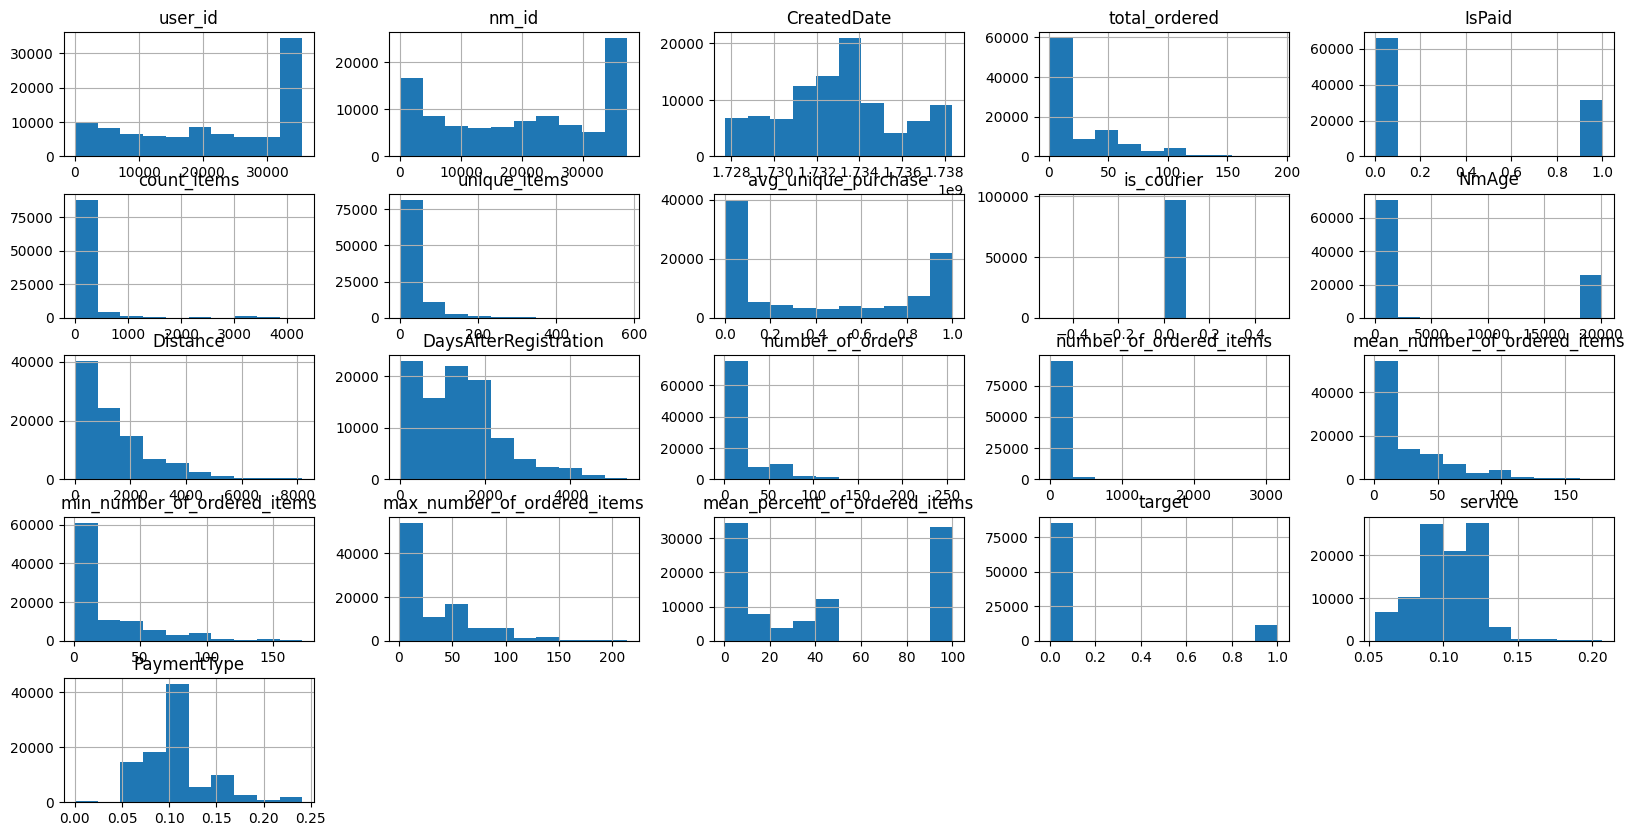

In [109]:
#Рассмотрим распределения данных
train_df_nocat.hist(figsize=(20, 10), layout=(-1, 5))
plt.show()


In [9]:
def antitrash(df, coef):
    df_antitrash = df[(np.abs(stats.zscore(df)) < coef).all(axis=1)]
    return(df_antitrash)

train_df_nocat['IsPaid'] = train_df_nocat['IsPaid'].astype(int)
train_df_nocat_antitrash = antitrash(df = train_df_nocat, coef = 4)
train_df_nocat_antitrash.describe()
#train_df_nocat_antitrash.hist(figsize=(20, 10), layout=(-1, 5))
#plt.show()

,user_id,nm_id,CreatedDate,total_ordered,IsPaid,count_items,unique_items,avg_unique_purchase,is_courier,NmAge,...,DaysAfterRegistration,number_of_orders,number_of_ordered_items,mean_number_of_ordered_items,min_number_of_ordered_items,max_number_of_ordered_items,mean_percent_of_ordered_items,target,service,PaymentType
count,97270.000000,97270.000000,9.727000e+04,97270.000000,97270.000000,97270.000000,97270.000000,97270.000000,97270.0,97270.000000,...,97270.000000,97270.000000,97270.000000,97270.000000,97270.000000,97270.000000,97270.000000,97270.000000,97270.000000,97270.000000
mean,21785.823419,19971.552627,1.733047e+09,27.322402,0.323872,192.094675,30.498478,0.413286,0.0,5603.252884,...,1381.314568,17.549522,79.767266,27.482097,23.601665,32.731346,45.939171,0.118834,0.102376,0.108052
std,12146.119103,13223.017437,2.680888e+06,33.419457,0.467954,575.756246,53.373370,0.407960,0.0,8714.054397,...,982.571502,27.750429,125.578983,32.226065,31.769977,36.281135,41.718499,0.323595,0.020837,0.035830
min,5.000000,4.000000,1.727698e+09,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.390625,0.000000,0.054180,0.000279
25%,10568.000000,6896.250000,1.731282e+09,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,153.000000,...,588.000000,1.000000,26.000000,1.557895,1.000000,3.000000,4.761905,0.000000,0.087636,0.090323
50%,23418.500000,21332.000000,1.733098e+09,13.000000,0.000000,21.000000,12.000000,0.280000,0.0,362.000000,...,1357.000000,3.000000,54.000000,15.000000,10.000000,19.000000,33.333333,0.000000,0.104751,0.104118
75%,34642.000000,34117.750000,1.734594e+09,50.000000,1.000000,99.000000,38.000000,0.870000,0.0,20006.000000,...,1862.000000,21.000000,86.000000,50.000000,44.000000,50.000000,100.000000,0.000000,0.118814,0.115017
max,35433.000000,37224.000000,1.738356e+09,192.000000,1.000000,4286.000000,582.000000,1.000000,0.0,20120.000000,...,5334.000000,256.000000,3156.000000,178.833333,172.000000,214.000000,100.000000,1.000000,0.206748,0.240826


In [10]:
def remove_rows_with_custom_thresholds(df, threshold_dict):
    mask = pd.Series(True, index=df.index)
    for column, threshold in threshold_dict.items():
        mask &= df[column] <= threshold
    return df[mask]

thresholds = {
    'unique_items': 500,
    'number_of_orders': 180,
    'number_of_ordered_items': 1500
}

filtered_df = remove_rows_with_custom_thresholds(train_df_nocat_antitrash, thresholds)

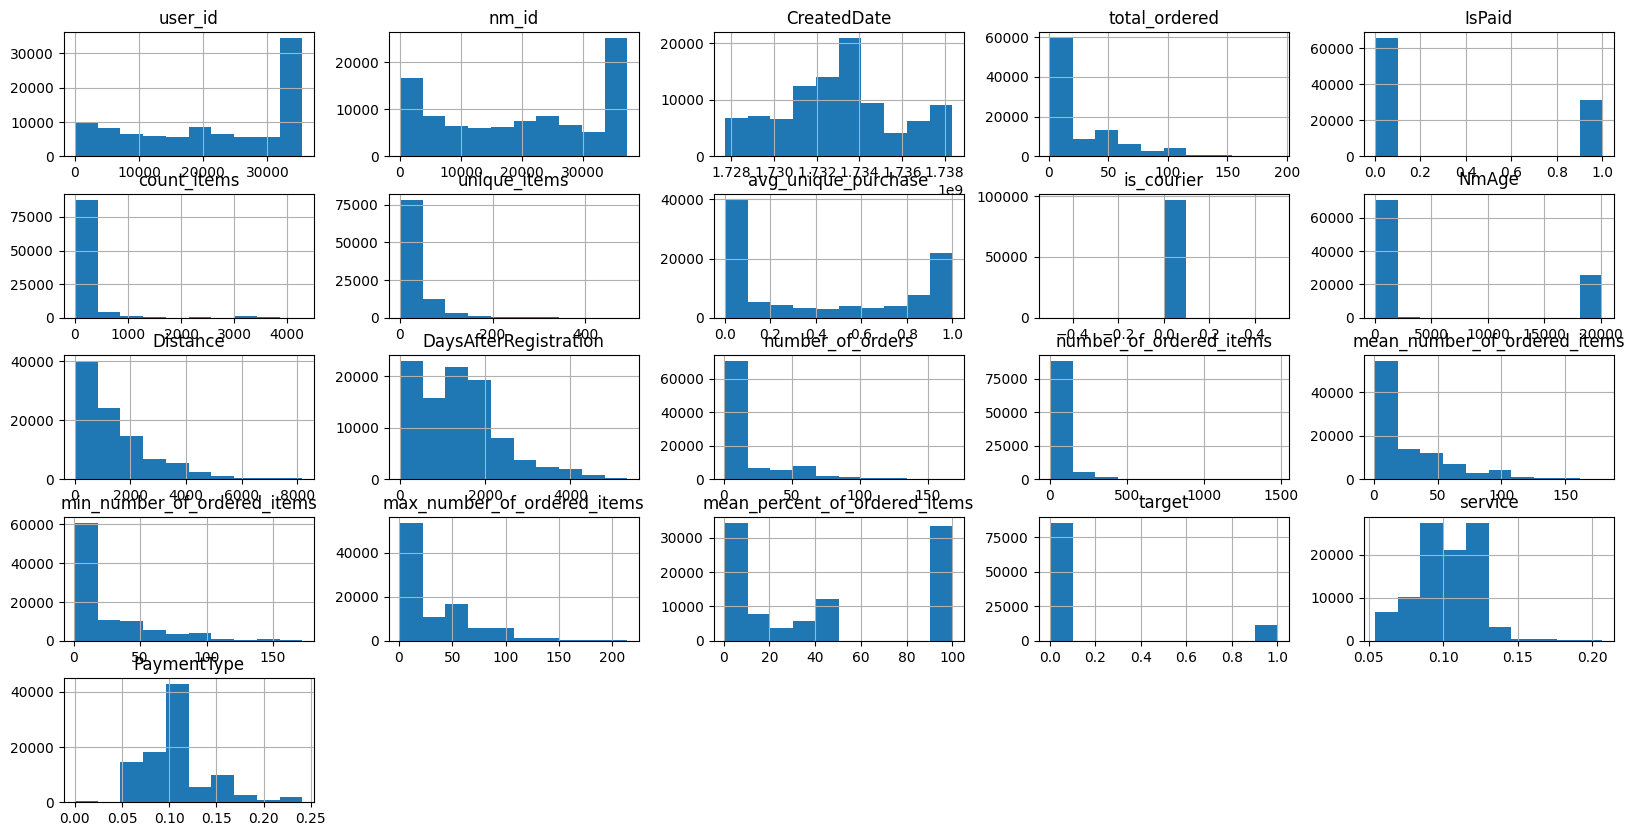

In [111]:
filtered_df.hist(figsize=(20, 10), layout=(-1, 5))
plt.show()

<ipython-input-39-d0d1982ce626>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.88983602 -1.88925892 -1.89739634 ...  0.97927372  0.97927372
 -0.19033015]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df_nocat_yj.update(transformed_data)
<ipython-input-39-d0d1982ce626>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.68762581 -1.68591023 -1.68517695 ...  0.36817423  0.36817423
  0.25788969]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df_nocat_yj.update(transformed_data)
<ipython-input-39-d0d1982ce626>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.91166586  1.90458668  1.90458668 ... -1.22025544 -1.22025544
 -1.22025544]' has dtype incompatible with int64,

array([[<Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'nm_id'}>,
        <Axes: title={'center': 'CreatedDate'}>,
        <Axes: title={'center': 'total_ordered'}>,
        <Axes: title={'center': 'IsPaid'}>],
       [<Axes: title={'center': 'count_items'}>,
        <Axes: title={'center': 'unique_items'}>,
        <Axes: title={'center': 'avg_unique_purchase'}>,
        <Axes: title={'center': 'is_courier'}>,
        <Axes: title={'center': 'NmAge'}>],
       [<Axes: title={'center': 'Distance'}>,
        <Axes: title={'center': 'DaysAfterRegistration'}>,
        <Axes: title={'center': 'number_of_orders'}>,
        <Axes: title={'center': 'number_of_ordered_items'}>,
        <Axes: title={'center': 'mean_number_of_ordered_items'}>],
       [<Axes: title={'center': 'min_number_of_ordered_items'}>,
        <Axes: title={'center': 'max_number_of_ordered_items'}>,
        <Axes: title={'center': 'mean_percent_of_ordered_items'}>,
        <Axes: title={'center': 'ta

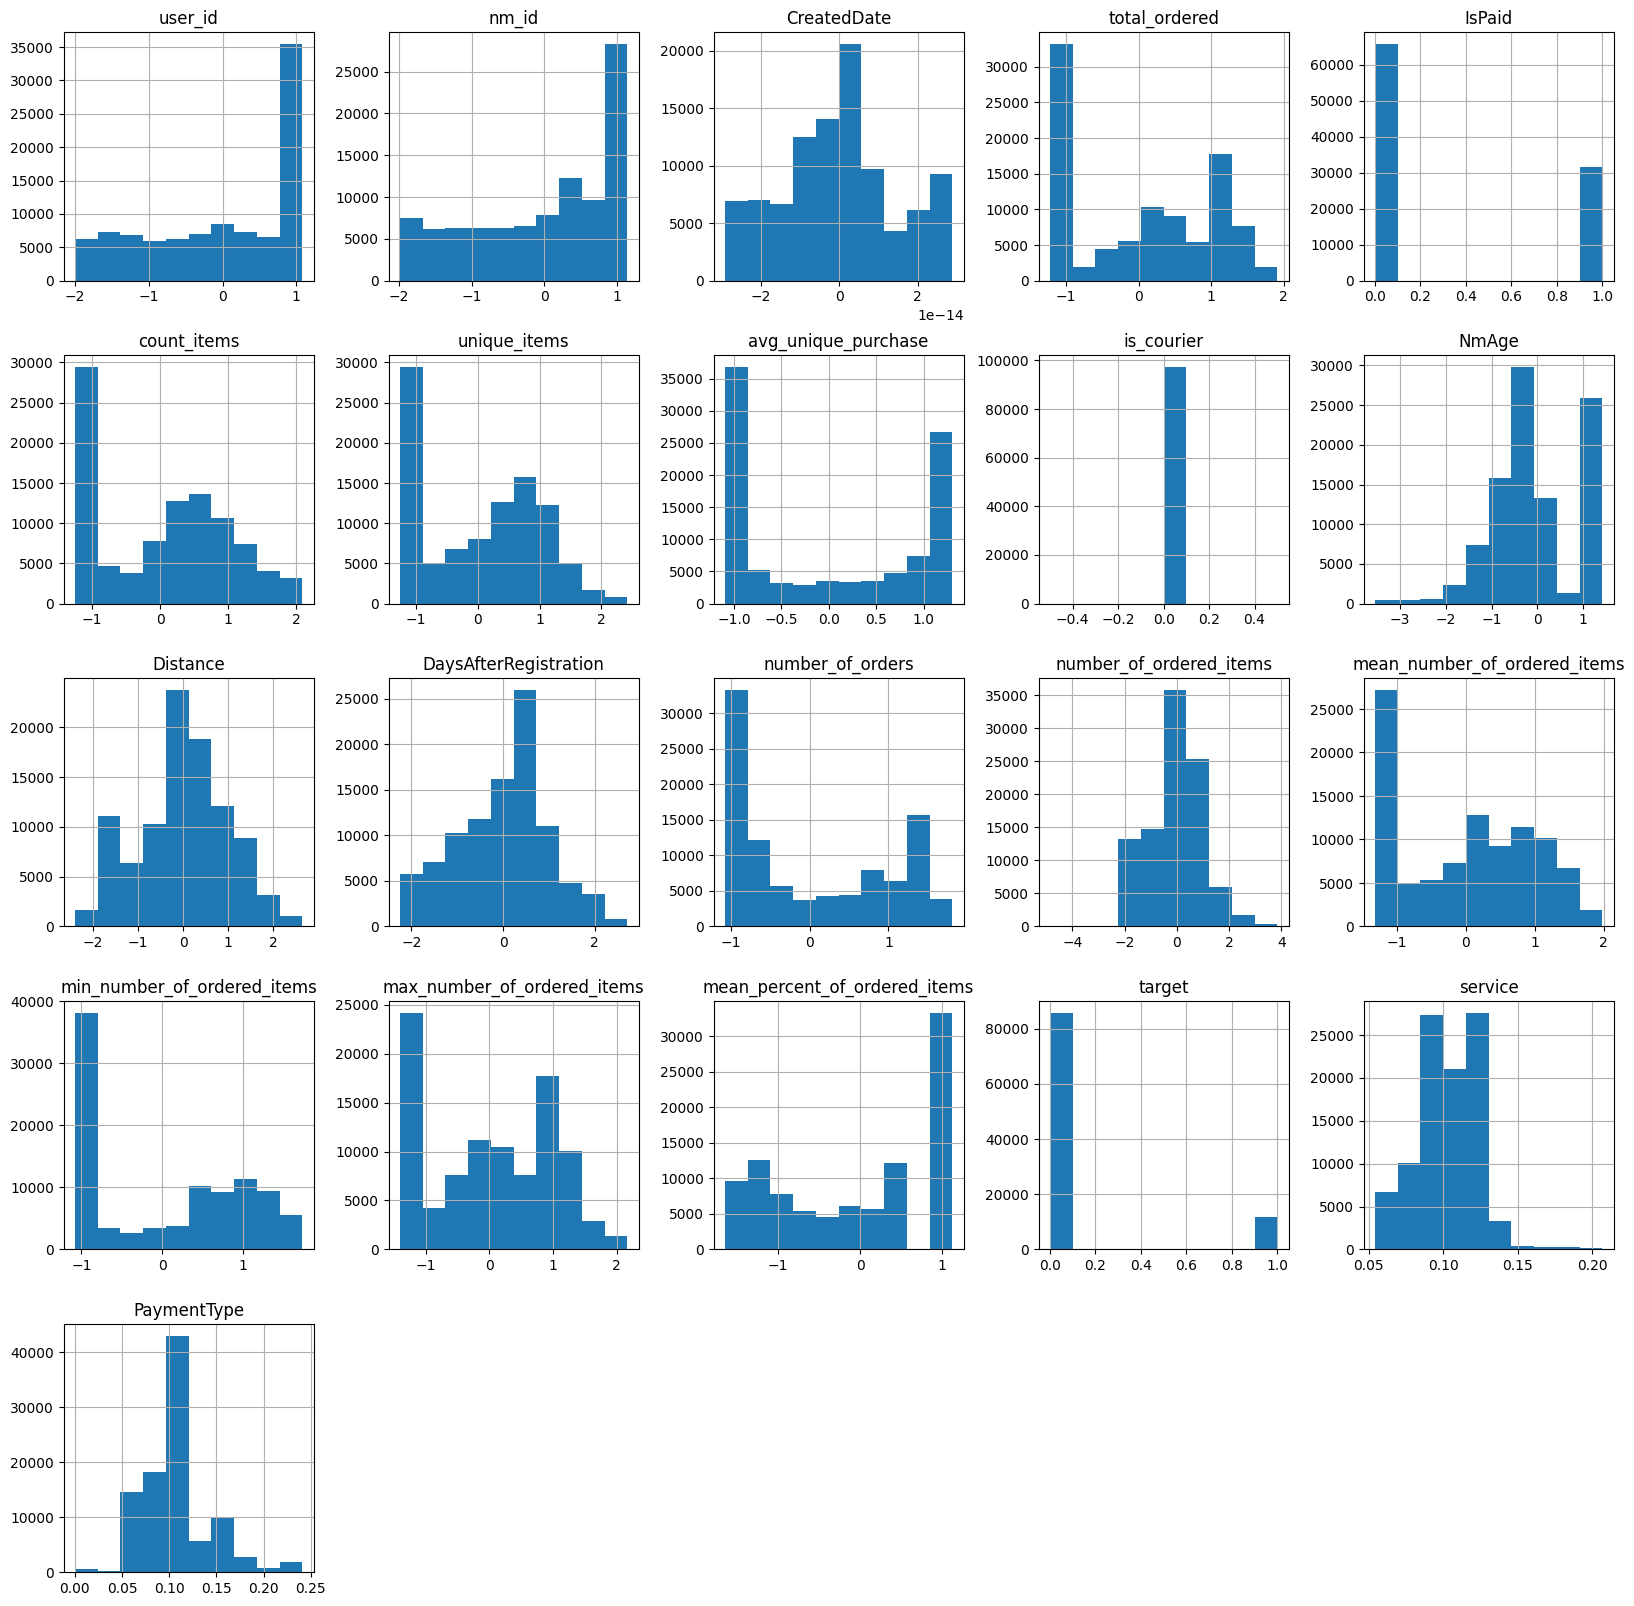

In [ ]:
columns_to_transform = ['user_id', 'nm_id', 'total_ordered', 'count_items', 'unique_items', 'avg_unique_purchase','NmAge','Distance','DaysAfterRegistration', 'number_of_orders', 'number_of_ordered_items', 'mean_number_of_ordered_items', 'min_number_of_ordered_items', 'max_number_of_ordered_items', 'mean_percent_of_ordered_items', 'CreatedDate']
# Инициализируем PowerTransformer с методом 'yeo-johnson'
train_df_nocat_yj = train_df_nocat_antitrash.copy()
pt = PowerTransformer(method='yeo-johnson', standardize=True)

transformed_data = pd.DataFrame(
    pt.fit_transform(train_df_nocat_antitrash[columns_to_transform]),
    columns=columns_to_transform,
    index=train_df_nocat_antitrash.index
)

train_df_nocat_yj.update(transformed_data)
train_df_nocat_yj.hist(figsize = (20, 20), layout = (-1, 5))

In [ ]:
train_df_nocat_yj.describe()

NameError: name 'train_df_nocat_yj' is not defined

/usr/local/lib/python3.11/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable is_courier for analysis 1. Dropping this column
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable is_courier for analysis 1. Dropping this column
  warnings.warn(


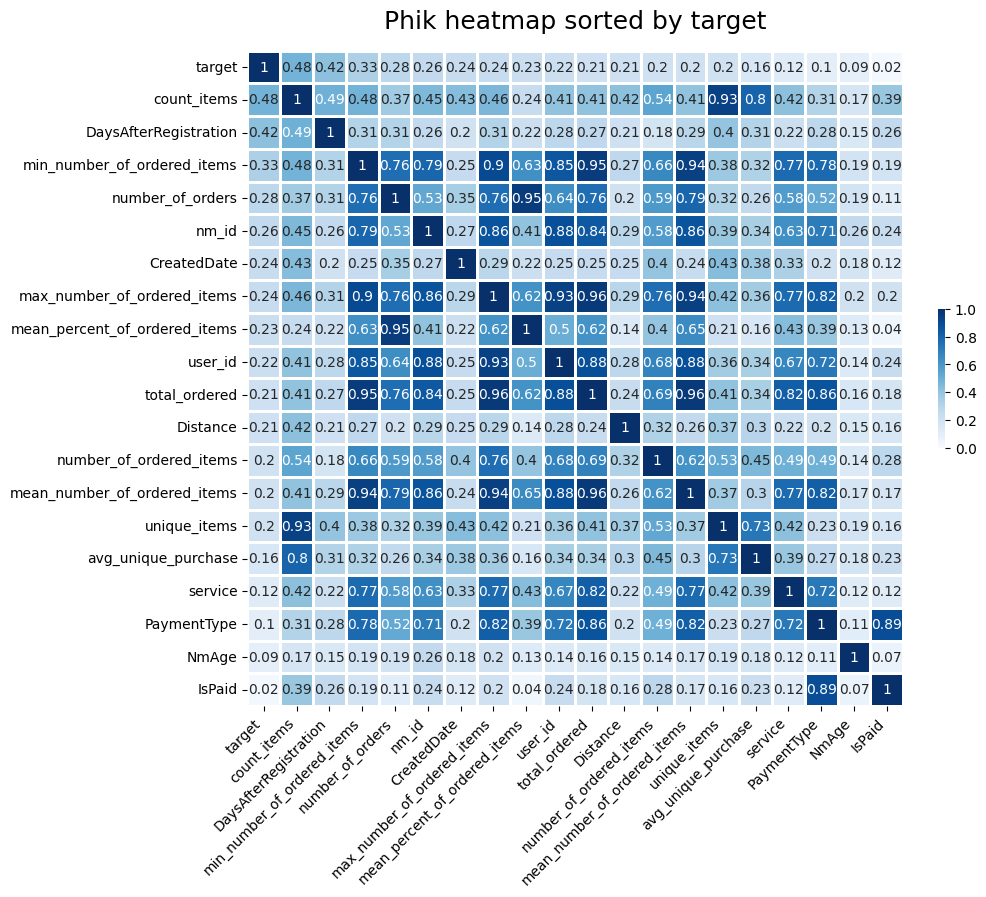

In [ ]:
def phiq_corr_mat(df):
    plt.figure(figsize=(9, 9))

    sorted_columns = (
        df.phik_matrix(interval_cols=df.columns)
        .round(2)
        .sort_values("target", ascending=False, axis=1)
        .columns
    )

    heatmap = sns.heatmap(
        df.phik_matrix(interval_cols=df.columns)
        .round(2)
        .sort_values("target", ascending=False, axis=1)
        .reindex(sorted_columns),
        annot=True,
        square=True,
        cmap="Blues",
        vmax=1,
        vmin=0,
        cbar_kws={"fraction": 0.01},  # shrink colour bar
        linewidth=2,
    )

    heatmap.set_xticklabels(
        heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
    )
    heatmap.set_title("Phik heatmap sorted by target", fontdict={"fontsize": 18}, pad=16)
    plt.show()
phiq_corr_mat(train_df_nocat_yj)

In [ ]:
sns.pairplot(filtered_df, figsize = (5,5))

# Решение проблемы дисбаланса классов

In [21]:
from imblearn.combine import SMOTEENN

X = filtered_df.drop('target', axis = 1)
y = filtered_df['target']
sme = SMOTEENN(random_state=42)
X_res, y_res = sme.fit_resample(X, y)


In [51]:
X_res.describe()

,user_id,nm_id,CreatedDate,total_ordered,IsPaid,count_items,unique_items,avg_unique_purchase,is_courier,NmAge,Distance,DaysAfterRegistration,number_of_orders,number_of_ordered_items,mean_number_of_ordered_items,min_number_of_ordered_items,max_number_of_ordered_items,mean_percent_of_ordered_items,service,PaymentType
count,159048.000000,159048.000000,1.590480e+05,159048.000000,159048.000000,159048.000000,159048.000000,159048.000000,159048.0,159048.000000,159048.000000,159048.000000,159048.000000,159048.000000,159048.000000,159048.000000,159048.000000,159048.000000,159048.000000,159048.000000
mean,23029.029004,18874.696796,1.733430e+09,21.856553,0.313886,441.245831,27.829831,0.399564,0.0,5499.905582,1360.933511,1076.073167,22.885638,94.940974,22.217166,17.866977,28.250811,33.510480,0.104554,0.110513
std,12489.749282,14093.230919,2.746169e+06,30.852228,0.464072,1056.620794,42.646177,0.412929,0.0,8623.072156,1348.351888,939.510881,27.681285,135.085085,29.822768,28.574262,35.194484,38.386795,0.019528,0.033690
min,5.000000,4.000000,1.727698e+09,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,6.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.595238,0.054180,0.000279
25%,11261.000000,3831.000000,1.731509e+09,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,173.000000,466.000000,262.000000,2.000000,42.000000,1.072727,1.000000,2.000000,2.272727,0.088398,0.093803
50%,28057.000000,20363.500000,1.733305e+09,6.000000,0.000000,20.000000,11.000000,0.210000,0.0,358.000000,861.000000,877.000000,9.000000,59.000000,7.500000,2.000000,12.000000,11.111111,0.108516,0.105000
75%,34874.000000,34904.250000,1.735739e+09,31.000000,1.000000,113.000000,43.000000,0.860000,0.0,20002.000000,1857.000000,1642.000000,45.000000,98.000000,32.000000,22.000000,50.000000,50.000000,0.119248,0.116793
max,35433.000000,37224.000000,1.738356e+09,192.000000,1.000000,4286.000000,491.000000,1.000000,0.0,20120.000000,8154.000000,5334.000000,168.000000,1474.000000,178.833333,172.000000,214.000000,100.000000,0.206748,0.240826


In [23]:
df_check = X_res
df_check['target'] = y_res
X_res

,user_id,nm_id,CreatedDate,total_ordered,IsPaid,count_items,unique_items,avg_unique_purchase,is_courier,NmAge,...,DaysAfterRegistration,number_of_orders,number_of_ordered_items,mean_number_of_ordered_items,min_number_of_ordered_items,max_number_of_ordered_items,mean_percent_of_ordered_items,service,PaymentType,target
0,-1.770144,-1.299914,1.562721,11.216621,-0.727986,-0.436760,-0.278407,-0.124975,-0.086217,1.720213,...,-0.084594,-0.407782,0.551340,5.412200,2.473915,9.323292,-0.334055,-2.966873,-1.366861,0
1,-1.770066,-1.299844,-0.278040,11.164126,1.373652,-0.441356,-0.297048,-0.929254,-0.086217,-0.611977,...,0.610471,-0.448215,0.231228,4.377398,-0.559305,9.278898,0.014997,-3.218933,-1.965497,0
2,-1.769988,-1.299774,-0.116873,11.164126,1.373652,-0.441356,-0.297048,-0.929254,-0.086217,1.714023,...,-1.110342,-0.488649,0.173920,11.764888,13.197419,9.278898,1.760256,-3.386974,-2.264815,0
3,-1.769910,-1.299704,1.700522,11.006641,1.373652,-0.364759,-0.278407,-0.880510,-0.086217,1.720680,...,0.671552,-0.488649,0.170447,11.598877,13.013587,9.145717,1.760256,0.814036,-2.444406,0
4,-1.769832,-1.299634,-0.278317,10.114227,1.373652,-0.441356,-0.297048,-0.929254,-0.086217,-0.552420,...,0.646277,-0.488649,0.150766,10.658148,11.971875,8.391023,1.760256,-3.507003,-2.564133,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171709,0.791553,-1.295999,0.708064,-0.568492,1.373652,2.952647,0.420602,-0.904882,-0.086217,-0.593643,...,-0.852325,0.582840,0.034414,-0.578851,-0.528666,-0.554317,-0.809153,-0.677574,0.385339,1
171710,0.961041,1.218254,-0.399939,-0.620987,-0.727986,-0.441356,-0.297048,-0.929254,-0.086217,-0.616415,...,-0.276264,-0.124747,-0.074413,-0.655357,-0.559305,-0.665301,-0.719849,0.351905,-0.292401,1
171711,0.970726,1.282362,1.287108,-0.620987,-0.727986,-0.424504,-0.185206,0.386839,-0.086217,-0.560361,...,0.587302,0.501973,-0.057626,-0.658270,-0.559305,-0.687498,-0.805275,0.362683,-0.282674,1
171712,0.791553,-1.210219,-0.472429,-0.542245,1.373652,2.048039,0.252839,-0.904882,-0.086217,1.712739,...,-0.891291,-0.185397,-0.055889,-0.594286,-0.528666,-0.576514,-0.694015,-0.201501,0.184668,1


In [156]:
y_res.value_counts()

,count
target,
1,81811
0,77237


## Подбор модели, её гиперпараметров и признаков

In [12]:
test_df_date = test_df
test_df_date['CreatedDate'] = pd.to_datetime(test_df['CreatedDate'], utc=True)
test_df_date['CreatedDate'] = test_df_date['CreatedDate'].astype('int64')/ 1e9

In [13]:
test_df_labels = test_df_date['target']
test_df_features = test_df_date.drop('target', axis = 1)

In [63]:
def cat_encoding_test(df, cat_cols):
    test_features_nocat = encoder.transform(df[cat_cols])
    df = df.drop(columns = cat_cols)
    test_features_nocat = pd.concat([df, test_features_nocat], axis = 1)
    return(test_features_nocat)
cat_cols = ['service', 'PaymentType']
test_features_nocat = cat_encoding_test(test_df_features, cat_cols)

In [157]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

In [130]:
train_val_labels = y_res
#train_val_data = X_res
train_val_data = X_res.drop(['user_id', 'CreatedDate', 'PaymentType', 'is_courier', 'IsPaid', 'service', 'number_of_ordered_items', 'nm_id', 'max_number_of_ordered_items', 'min_number_of_ordered_items', 'mean_number_of_ordered_items', 'total_ordered', 'number_of_orders', 'unique_items', 'Distance'], axis = 1)
X_train, X_val, y_train, y_val = train_test_split(train_val_data, train_val_labels, test_size = 0.2, random_state = 15, shuffle=True)


In [131]:
test_features = test_features_nocat.drop(['user_id', 'CreatedDate', 'PaymentType', 'is_courier', 'IsPaid', 'service', 'number_of_ordered_items', 'nm_id', 'max_number_of_ordered_items', 'min_number_of_ordered_items', 'mean_number_of_ordered_items', 'total_ordered', 'number_of_orders', 'unique_items', 'Distance'], axis = 1)
test_df_labels = test_df_date['target']


In [147]:
catboost = CatBoostClassifier(verbose=0, random_state=42, early_stopping_rounds=10, depth = 4, l2_leaf_reg = 3, learning_rate = 0.03, iterations = 200)
catboost.fit(X_train, y_train)

In [159]:
joblib.dump(catboost, 'catboost_model.joblib')

['catboost_model.joblib']

In [151]:
catboost.set_probability_threshold(binclass_probability_threshold=0.6)

y_pred_test = catboost.predict(test_features)
y_proba_test = catboost.predict_proba(test_features)[:, 1]  # для ROC AUC

print("Accuracy:", accuracy_score(test_df_labels, y_pred_test))
print("Precision:", precision_score(test_df_labels, y_pred_test))
print("Recall:", recall_score(test_df_labels, y_pred_test))
print("F1 Score:", f1_score(test_df_labels, y_pred_test))
print("ROC AUC:", roc_auc_score(test_df_labels, y_proba_test))
print("Confusion Matrix:\n", confusion_matrix(test_df_labels, y_pred_test))
print("\nClassification Report:\n", classification_report(test_df_labels, y_pred_test))

y_pred_val = catboost.predict(X_val)
y_proba_val = catboost.predict_proba(X_val)[:, 1]  # для ROC AUC
print("\nClassification Report:\n", classification_report(y_val, y_pred_val))

Accuracy: 0.8553397377463011
Precision: 0.4119259766963674
Recall: 0.3327796234772979
F1 Score: 0.3681470137825421
ROC AUC: 0.6111716020419913
Confusion Matrix:
 [[11597   858]
 [ 1205   601]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92     12455
           1       0.41      0.33      0.37      1806

    accuracy                           0.86     14261
   macro avg       0.66      0.63      0.64     14261
weighted avg       0.84      0.86      0.85     14261


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.92      0.84     15499
           1       0.91      0.76      0.82     16311

    accuracy                           0.83     31810
   macro avg       0.84      0.84      0.83     31810
weighted avg       0.85      0.83      0.83     31810



In [152]:
import sys
catboost.get_feature_importance(data=Pool(data = X_res, label = y_res),
                       reference_data=None,
                       #type=EFstrType.FeatureImportance,
                       prettified=True,
                       thread_count=-1,
                       verbose=True,
                       log_cout=sys.stdout,
                       log_cerr=sys.stderr
                        )

Used dataset leave statistics for fstr calculation


,Feature Id,Importances
0,mean_percent_of_ordered_items,50.549838
1,DaysAfterRegistration,16.958604
2,count_items,14.656616
3,NmAge,9.095784
4,avg_unique_purchase,8.739159


#Пробуем Логистическую регрессию в качестве классификатора

In [147]:
from sklearn.linear_model import LogisticRegression

In [159]:
param_grid = {
    'C': [0.01, 0.05, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['newton-cholesky']
}

grid = GridSearchCV(LogisticRegression(max_iter=2000, class_weight = 'balanced'), param_grid, cv=5, scoring='f1_weighted')
grid.fit(train_val_data, train_val_labels)

# 9. Предсказания и метрики
y_pred = grid.predict(test_features)
y_proba = grid.predict_proba(test_features)[:, 1]

print("Лучшие параметры:", grid.best_params_)
print("\nClassification Report:\n", classification_report(test_df_labels, y_pred))
print("Confusion Matrix:\n", confusion_matrix(test_df_labels, y_pred))
print("ROC AUC Score:", roc_auc_score(test_df_labels, y_proba))

model = grid.best_estimator_

coefs = pd.Series(model.coef_[0])

print("\nТоп-10 важных признаков:")
print(coefs.head(10))

# === 5. Классификация с пользовательским порогом ===
y_proba = model.predict_proba(X_test_all)[:, 1]
custom_threshold = 0.3
y_pred_custom = (y_proba >= custom_threshold).astype(int)

print(f"\nМетрики при пороге = {custom_threshold}")
print("Classification Report:\n", classification_report(y_test, y_pred_custom))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Лучшие параметры: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cholesky'}

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.75      0.82     12455
           1       0.22      0.49      0.30      1806

    accuracy                           0.72     14261
   macro avg       0.57      0.62      0.56     14261
weighted avg       0.82      0.72      0.76     14261

Confusion Matrix:
 [[9370 3085]
 [ 929  877]]
ROC AUC Score: 0.6700892648751452


In [ ]:
best_model_Lin.get_feature_importance(data=Pool(data = train_val_data, label = train_val_labels),
                       reference_data=None,
                       #type=EFstrType.FeatureImportance,
                       prettified=True,
                       thread_count=-1,
                       verbose=True,
                       log_cout=sys.stdout,
                       log_cerr=sys.stderr
                        )

#Пробуем сделать через встроенные праметры Catboost Classifier

In [28]:
X_train_val= train_df_nocat.drop('target', axis = 1)
y_train_val = train_df_nocat['target']
scaler = StandardScaler()
scaler.fit(X)
train_val_data_for_weights = pd.DataFrame(scaler.transform(X), columns = X.columns)

In [37]:
train_val_data_for_weights

,user_id,nm_id,CreatedDate,total_ordered,IsPaid,count_items,unique_items,avg_unique_purchase,is_courier,NmAge,Distance,DaysAfterRegistration,number_of_orders,number_of_ordered_items,mean_number_of_ordered_items,min_number_of_ordered_items,max_number_of_ordered_items,mean_percent_of_ordered_items,service,PaymentType
0,-1.695964,-1.452642,1.110153,14.722527,-0.728190,-0.246837,-0.219209,1.465897,-0.115848,-0.623190,1.139472,-1.301137,-0.330641,0.219158,15.457113,16.380175,13.228959,1.300832,0.880309,0.494280
1,-1.695884,-1.452567,-0.853122,11.885283,1.373269,-0.250746,-0.247554,-0.993193,-0.115848,-0.530539,1.160591,-0.131987,-0.313689,0.209598,7.064824,1.863924,10.653890,0.104268,-1.577923,0.494280
2,-1.695804,-1.452493,0.317190,11.589223,1.373269,-0.250746,-0.247554,-0.993193,8.632001,-0.588229,-0.472818,2.646251,-0.330641,0.161345,12.167543,12.921331,10.385188,1.300832,-2.397334,-1.216418
3,-1.695724,-1.452418,1.731844,10.404981,-0.728190,-0.244882,-0.233381,-0.181693,-0.115848,1.683844,-0.477646,-0.393137,-0.262834,0.435387,4.925308,2.027334,9.310376,-0.613671,-2.807039,-1.216418
4,-1.695644,-1.452344,-0.138063,10.355638,1.373269,-0.250746,-0.247554,-0.993193,-0.115848,-0.620421,-0.280937,0.269783,-0.296737,0.183651,3.956569,-0.668930,9.265592,-0.294587,-3.052863,-1.786651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105560,0.931926,1.281223,0.308367,-0.721951,1.373269,3.822124,0.227233,-0.968602,-0.115848,-0.606113,-0.579621,-1.142438,-0.296737,-0.064899,-0.757618,-0.668930,-0.788372,-0.294587,1.141598,1.549945
105561,-1.562250,-1.311498,-2.009063,-0.721951,-0.728190,-0.250746,-0.247554,-0.993193,-0.115848,-0.632651,-0.674958,-0.291691,-0.313689,-0.002079,1.042580,-0.668930,2.324103,0.104268,1.142050,0.246684
105562,1.029347,0.262904,-1.064354,-0.721951,-0.728190,-0.250746,-0.247554,-0.993193,-0.115848,-0.426697,-0.370240,-0.177186,-0.279786,-0.058526,-0.673436,-0.668930,-0.586845,-0.494014,0.250234,0.246638
105563,1.029347,0.262904,-1.064377,-0.721951,-0.728190,-0.250746,-0.247554,-0.993193,-0.115848,-0.426697,-0.370240,-0.177186,-0.279786,-0.058526,-0.673436,-0.668930,-0.586845,-0.494014,0.251348,0.246985


In [30]:
len(y_train_val[y_train_val == 0]) / len(y_train_val[y_train_val == 1])

6.905122060805751

In [31]:
def cat_encoding_test(df, cat_cols):
    test_features_nocat = encoder.transform(df[cat_cols])
    df = df.drop(columns = cat_cols)
    test_features_nocat = pd.concat([df, test_features_nocat], axis = 1)
    return(test_features_nocat)
cat_cols = ['service', 'PaymentType']

test_features_nocat = cat_encoding_test(test_df_features, cat_cols)
test_features_standard = pd.DataFrame(scaler.transform(test_features_nocat), columns = test_features_nocat.columns)

In [ ]:
test_features_nocat

In [35]:
test_df_labels = test_df_labels
test_df_features = test_features_standard

In [36]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

model = CatBoostClassifier(verbose = 0,
                           scale_pos_weight = len(y_train_val[y_train_val == 0]) / len(y_train_val[y_train_val == 1]))  # убираем лишний вывод

param_grid = {
    'depth': [4, 6, 8],
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64]
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1
)

grid.fit(train_val_data_for_weights, y_train_val)

print("Best score:", grid.best_score_)
print("Best params:", grid.best_params_)

best_model = grid.best_estimator_

Best score: 0.5639181620645345
Best params: {'border_count': 32, 'depth': 8, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1}


In [38]:
y_pred = best_model.predict(test_df_features)
y_proba = best_model.predict_proba(test_df_features)[:, 1]  # для ROC AUC

print("Accuracy:", accuracy_score(test_df_labels, y_pred))
print("Precision:", precision_score(test_df_labels, y_pred))
print("Recall:", recall_score(test_df_labels, y_pred))
print("F1 Score:", f1_score(test_df_labels, y_pred))
print("ROC AUC:", roc_auc_score(test_df_labels, y_proba))
print("Confusion Matrix:\n", confusion_matrix(test_df_labels, y_pred))
print("\nClassification Report:\n", classification_report(test_df_labels, y_pred))

Accuracy: 0.8601079868171937
Precision: 0.30105263157894735
Recall: 0.07918050941306755
F1 Score: 0.12538360368259535
ROC AUC: 0.5244071125598111
Confusion Matrix:
 [[12123   332]
 [ 1663   143]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92     12455
           1       0.30      0.08      0.13      1806

    accuracy                           0.86     14261
   macro avg       0.59      0.53      0.52     14261
weighted avg       0.81      0.86      0.82     14261

